### Task 2. Controllable Generation: Joint Diffusion for Panorama Generation


In [1]:
import os
from os.path import join

import torch
import torch.nn as nn
from torch.autograd import grad
import torchvision.transforms as T
from PIL import Image

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
import lpips

# Set CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2023-07-20 20:46:04.490412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


##### Define utility functions

In [2]:
''' Fix the seed for for reproducibility '''
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

''' Given the SD version, return its Huggingface model ID '''
def set_sd_model_id(sd_version):
    if sd_version == "v1-4":
        model_id = "CompVis/stable-diffusion-v1-4"
    elif sd_version == "v1-5":
        model_id = "runwayml/stable-diffusion-v1-5"
    elif sd_version == "v2-0":
        model_id = "stabilityai/stable-diffusion-2"
    elif sd_version == "v2-1":
        model_id = "stabilityai/stable-diffusion-2-1"
    else:
        raise ValueError("Invalid sd_version")
    return model_id

''' Returns the list of window positions for joint diffusion process. '''
def get_windows(panorama_height, panorama_width, window_size=64, stride=8):
    panorama_height /= 8
    panorama_width /= 8
    num_blocks_height = (panorama_height - window_size) // stride + 1
    num_blocks_width = (panorama_width - window_size) // stride + 1
    total_num_blocks = int(num_blocks_height * num_blocks_width)
    
    windows = []
    for i in range(total_num_blocks):
        h_start = int((i // num_blocks_width) * stride)
        h_end = h_start + window_size
        w_start = int((i % num_blocks_width) * stride)
        w_end = w_start + window_size
        windows.append((h_start, h_end, w_start, w_end))
    
    return windows

''' Returns the list of decayed weights for synchronized joint diffusion. '''
def exponential_decay_list(init_weight, decay_rate, num_steps):
    weights = [init_weight * (decay_rate ** i) for i in range(num_steps)]
    return torch.tensor(weights)

##### Implement `JointDiffusion` module for enabling joint diffusion processes.

In [3]:
class JointDiffusion(nn.Module):
    def __init__(self, sd_version='v1-5', device='cuda'):
        
        super().__init__()
        self.device = device

        # Set Huggingface model ID
        model_id = set_sd_model_id(sd_version)
        print(f"[INFO] Model ID: {model_id}")

        # Load pretrained modules from Huggingface
        self.vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae").to(self.device)
        self.tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
        self.text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder").to(self.device)
        self.unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet").to(self.device)

        # Freeze models
        for p in self.unet.parameters():
            p.requires_grad_(False)
        for p in self.vae.parameters():
            p.requires_grad_(False)
        for p in self.text_encoder.parameters():
            p.requires_grad_(False)

        self.unet.eval() 
        self.vae.eval()
        self.text_encoder.eval()
        print('[INFO] Loaded Stable Diffusion!')

        # Set DDIM scheduler
        self.scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
        print('[INFO] Loaded DDIM scheduler!')

        # Load perceptual loss (LPIPS) module
        self.percept_loss = lpips.LPIPS(net='vgg').to(self.device)
        print(f'[INFO] Loaded perceptual loss module!')

    def get_text_embeddings(self, prompt, negative_prompt=""):
        '''
        Given a text prompt, return the text embeddings.
        '''

        # Tokenize text prompt and obtain embeddings
        text_input = self.tokenizer(prompt, padding='max_length', max_length=self.tokenizer.model_max_length, return_tensors='pt')
        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        # Repeat for unconditional embeddings
        uncond_input = self.tokenizer(negative_prompt, padding='max_length', max_length=self.tokenizer.model_max_length, return_tensors='pt')
        uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

        # Concatenate conditional and unconditional embeddings
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        return text_embeddings
    
    def decode_latents(self, latents):
        '''
        Decode latents to images using VAE decoder.
        '''
        latents = 1 / 0.18215 * latents
        imgs = self.vae.decode(latents).sample
        imgs = (imgs / 2 + 0.5).clamp(0, 1)
        
        return imgs
    
    def joint_sample(
        self,
        prompts, 
        negative_prompts="", 
        height=512, 
        width=2048, 
        latent_size=64,                     # Fix latent size to 64 for Stable Diffusion
        num_sampling_steps=50,
        guidance_scale=7.5, 
        use_syncdiffusion=False,            # Use SyncDiffusion [Lee et al.]
        stride=16,                          # The stride for latents, set as 16 in the paper           
        sync_weight=20,                     # Gradient descent weight 'w' in SyncDiffusion paper
        sync_decay_rate=0.95,               # Decay rate for sync_weight, set as 0.95 in SyncDiffusion paper        
    ):
        '''
        Joint diffusion sampling pipeline for generating images with arbitrary resolution.
        '''

        assert height >= 512 and width >= 512, 'height and width must be at least 512'
        assert height % 8 == 0 and width % 8 == 0, 'height and width must be divisible by 8'
        assert stride % 8 == 0 and stride < 64, 'stride must be divisible by 8 and smaller than the latent size of Stable Diffusion'

        if isinstance(prompts, str):
            prompts = [prompts]

        if isinstance(negative_prompts, str):
            negative_prompts = [negative_prompts]

        # Obtain text embeddings
        text_embeds = self.get_text_embeddings(prompts, negative_prompts)                   # 2 x 77 x 768

        # Set the list of windows to process jointly
        windows_list = get_windows(height, width, stride=stride)
        print(f"[INFO] Number of joint diffusion processes: {len(windows_list)}")

        # Initialize latent (x_T) sampled from Gaussian distribution
        latent = torch.randn((1, self.unet.in_channels, height // 8, width // 8))           # 1 x 4 x (H//8) x (W//8)

        # Keep track of overlapping regions for latent averaging (See MultiDiffusion [Bar-Tal et al.])
        count = torch.zeros_like(latent, requires_grad=False, device=self.device)          
        value = torch.zeros_like(latent, requires_grad=False, device=self.device)
        latent = latent.to(self.device)

        # Set DDIM scheduler
        self.scheduler.set_timesteps(num_sampling_steps)
        
        # Set the anchor view as the middle view
        anchor_window_idx = len(windows_list) // 2

        # Set a scheduler for SyncDiffusion
        sync_scheduler = exponential_decay_list(
            init_weight=sync_weight,
            decay_rate=sync_decay_rate,
            num_steps=num_sampling_steps
        )
        print(f'[INFO] Using exponential decay scheduler with decay rate {sync_decay_rate}')

        with torch.autocast('cuda'):
            # Sampling loop
            for i, t in enumerate(self.scheduler.timesteps):
                count.zero_()
                value.zero_()

                if use_syncdiffusion:
                    with torch.no_grad():
                        # TODO (4): Obtain the `foreseen denoised latent (x_0)` of the anchor window (See DDIM, SyncDiffusion paper).
                        # Then decode the latent to obtain the anchor image.
                        # HINT: Refer to the original sampling loop code of Stable Diffusion.

                        ############### ADD CODE HERE (4) ###############
                        decoded_image_anchor = None
                        ############### ADD CODE HERE (4) ###############


                # Perform single denoising step for each window
                for window_idx, (h_start, h_end, w_start, w_end) in enumerate(windows_list):
                    
                    # Get the latent for the current window
                    curr_latent = latent[:, :, h_start:h_end, w_start:w_end].detach()              # 1 x 4 x 64 x 64

                    # For SyncDiffusion, copy the current window latent & enable gradient computation
                    if use_syncdiffusion:
                        curr_latent_ori = curr_latent.clone().detach()
                        curr_latent.requires_grad_()

                    # Noise prediction with Unet
                    latent_model_input = torch.cat([curr_latent] * 2)
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeds)['sample']

                    # Perform classifier-free guidance (CFG)
                    noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
                    noise_pred_new = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

                    # `Denoise` the latent with the predicted noise
                    denoised_outputs = self.scheduler.step(noise_pred_new, t, curr_latent)

                    '''
                    NOTE: `denoised_outputs` consists of:
                        - `prev_sample`: One-step denoised latent at timestep t-1, x_{t-1}
                        - `pred_original_sample`: Foreseen fully denoised latent at timestep 0, x_0
                            (See DDIM paper for more details)
                    '''

                    if use_syncdiffusion:
                        # TODO (5): Update the current window latent by gradient descent comparing
                        # the perceptual similarity of current window and the anchor window. (See pseudocode in SyncDiffusion)

                        ############### ADD CODE HERE (5) ###############
                        
                        # Update the current window latent with the gradient
                        if window_idx != anchor_window_idx:
                            curr_latent_ori = None

                        # With the updated latent, take a denoising step
                        with torch.no_grad():
                            pass
                        
                        ############### ADD CODE HERE (5) ###############
                    else:
                        # TODO (1): Update the current window latent with the denoised latent (See MultiDiffusion)

                        ############### ADD CODE HERE (1) ###############
                        pass
                        ############### ADD CODE HERE (1) ###############


                    # TODO (2): Keep track of overlapping regions of latents (See MultiDiffusion)
                    # HINT: Update the `count` and `value` tensors

                    ############### ADD CODE HERE (2) ###############

                    ############### ADD CODE HERE (2) ###############
                
                # TODO (3): For overlapping region of latents, take the average of the latent values (See MultiDiffusion)
                # For non-overlapping region, take the value of the latent as it is.
                # NOTE: After implementing this part , you can now run MultiDiffusion with `use_syncdiffusion=False`.
                
                ############### ADD CODE HERE (3) ###############
                latent = None
                ############### ADD CODE HERE (3) ###############

                # (For debugging) Remove torch cache (for memory management)
                # torch.cuda.empty_cache()
                if (i + 1) % 10 == 0:
                    print(f"[INFO] step {i + 1} / {num_sampling_steps} done")

        # Decode latents to panorama image
        with torch.no_grad():
            imgs = self.decode_latents(latent)  # [1, 3, 512, 512]
            img = T.ToPILImage()(imgs[0].cpu())

        print('[INFO] Sampling finished!')

        return img

##### Load the implemented `JointDiffusion` module

In [4]:
joint_diffusion = JointDiffusion(sd_version='v1-5', device=device)

[INFO] Model ID: runwayml/stable-diffusion-v1-5
[INFO] Loaded Stable Diffusion!
[INFO] Loaded DDIM scheduler!
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/yuseung07/miniconda3/envs/ddpm/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
[INFO] Loaded perceptual loss module!


In [ ]:
######### Set parameters #########
prompts = "a beautiful landscape"
negative_prompts = ""
height = 512
width = 2048
stride = 16

use_syncdiffusion = False               # Set as False for MultiDiffusion

# Only for SyncDiffusion
sync_weight = 20
sync_decay_rate = 0.95

SEED = 2023
seed_everything(SEED)
######### Set parameters #########

image = joint_diffusion.joint_sample(
    prompts, 
    negative_prompts=negative_prompts, 
    height=height, 
    width=width, 
    latent_size=64,                    
    num_sampling_steps=50,
    guidance_scale=7.5, 
    use_syncdiffusion=use_syncdiffusion,       
    stride=stride,                     
    sync_weight=sync_weight,       
    sync_decay_rate=sync_decay_rate
)
image

##### Sample outputs

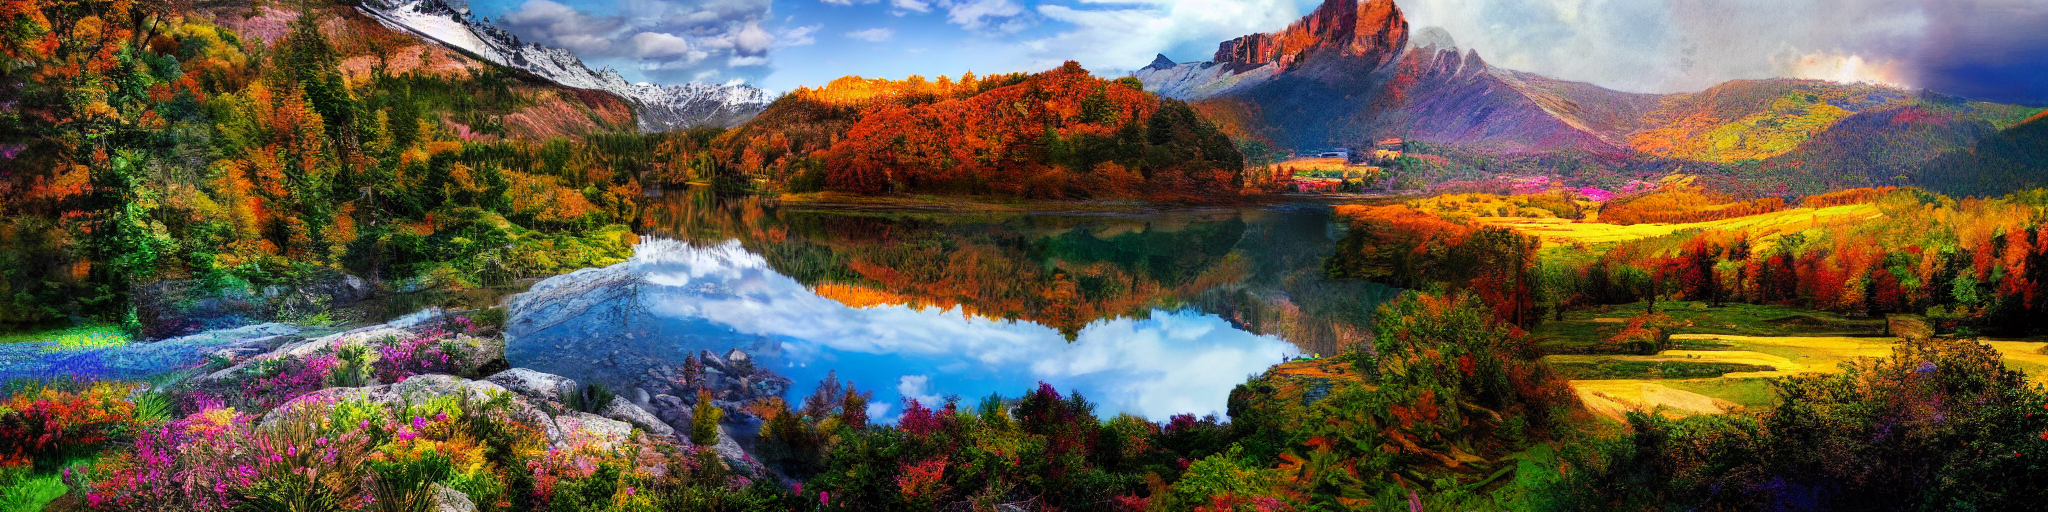

In [2]:
# MultiDiffusion
sample_image = Image.open("assets/sample_multidiffusion.png").convert("RGB")
sample_image

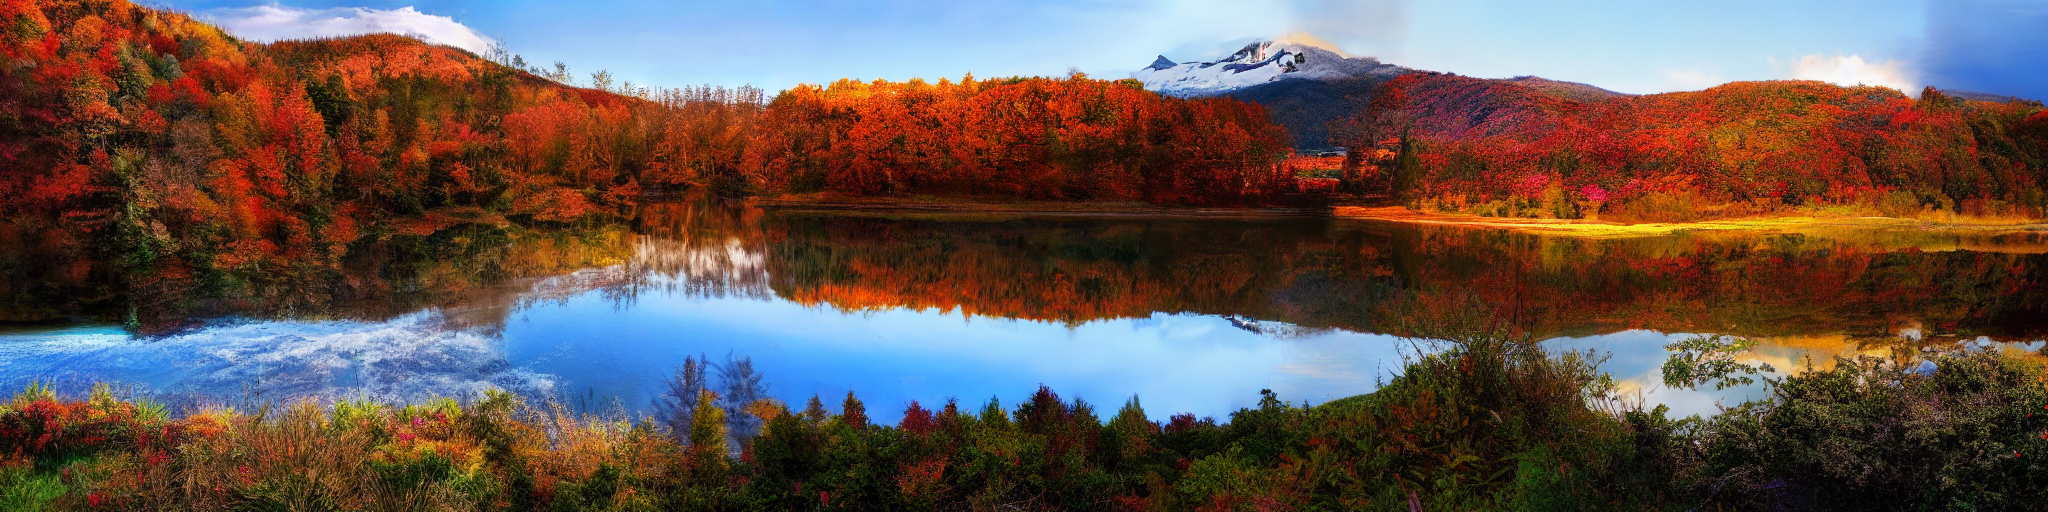

In [3]:
# SyncDiffusion
sample_image = Image.open("assets/sample_syncdiffusion.png").convert("RGB")
sample_image